# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv 
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Q1 part 1:
df = pd.read_csv('./data/cars_hw.csv')
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [2]:
df['age'] = max(df['Make_Year'])-df['Make_Year']

In [3]:
# Rescaling price and age variables
df['price_ihs'] = np.arcsinh(df['Price'])
df['age_ihs'] = np.arcsinh(df['age'])

<AxesSubplot:>

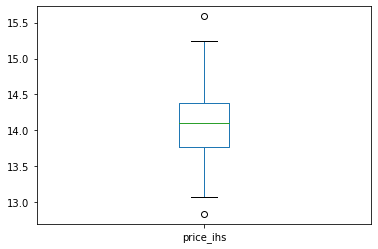

In [4]:
df['price_ihs'].plot.box()

<AxesSubplot:>

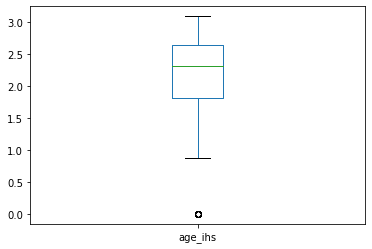

In [5]:
df['age_ihs'].plot.box()

<AxesSubplot:xlabel='age_ihs', ylabel='price_ihs'>

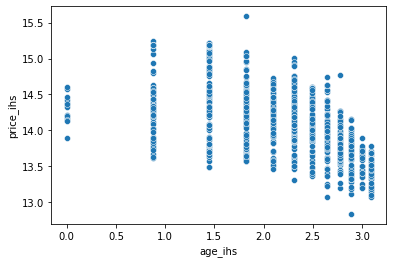

In [6]:
sns.scatterplot(data=df,y='price_ihs',x='age_ihs')

In [7]:
# Drop outliers:
df = df.loc[df['price_ihs']<15.5,:]
df = df.loc[df['price_ihs']>13,:]
df = df.loc[df['age_ihs']>0.5,:]

<AxesSubplot:xlabel='age_ihs', ylabel='price_ihs'>

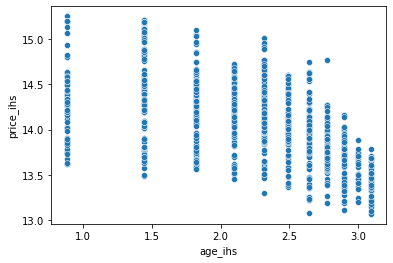

In [8]:
sns.scatterplot(data=df,y='price_ihs',x='age_ihs')

In [9]:
# Q1 part 2:
df['Price'].describe()

count    9.600000e+02
mean     7.380156e+05
std      3.624399e+05
min      2.370000e+05
25%      4.717500e+05
50%      6.615000e+05
75%      8.822500e+05
max      2.100000e+06
Name: Price, dtype: float64

<AxesSubplot:xlabel='Price', ylabel='Density'>

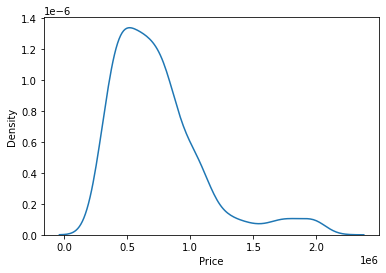

In [10]:
sns.kdeplot(data=df, x='Price')

In [11]:
df['Price'].describe()

count    9.600000e+02
mean     7.380156e+05
std      3.624399e+05
min      2.370000e+05
25%      4.717500e+05
50%      6.615000e+05
75%      8.822500e+05
max      2.100000e+06
Name: Price, dtype: float64

In [12]:
prices_make = df['Price'].groupby(df['Make'])
prices_make.describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,4.535000e+05,246606.366503,267000.0,288500.0,345500.0,537500.0,892000.0
Datsun,3.0,2.896667e+05,10503.967504,279000.0,284500.0,290000.0,295000.0,300000.0
Ford,52.0,7.211731e+05,140927.699605,290000.0,635000.0,707500.0,787000.0,1066000.0
Honda,73.0,7.989726e+05,266509.066586,316000.0,581000.0,785000.0,915000.0,1537000.0
Hyundai,303.0,6.910924e+05,279859.492966,248000.0,484500.0,638000.0,836500.0,1742000.0
Jeep,4.0,1.499500e+06,152513.387391,1290000.0,1447500.0,1529500.0,1581500.0,1649000.0
Kia,8.0,1.614750e+06,119056.709177,1369000.0,1579000.0,1628500.0,1705750.0,1741000.0
MG Motors,35.0,1.869457e+06,121661.135671,1589000.0,1786500.0,1848000.0,1978000.0,2019000.0
Mahindra,18.0,1.100167e+06,175549.305961,796000.0,1037000.0,1094500.0,1157000.0,1465000.0


<AxesSubplot:xlabel='Price', ylabel='Density'>

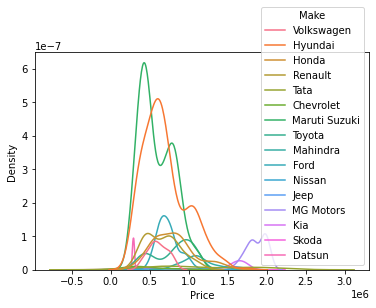

In [13]:
sns.kdeplot(data=df, x='Price', hue='Make')
# I tried to move the legend, but I wasn't able to do so without making a label,
# however making a label such as 'Make' would replace each brand as the string 'Make',
# so I ended up just not moving the legend

In [14]:
# Q1 part 3:


y = df['Price'] # Create target variable vector

# Create feature matrix with numeric variables only
X = df.drop('Make',axis=1).drop('Color',axis=1).drop('Body_Type',axis=1).drop('No_of_Owners',axis=1).drop('Fuel_Type',axis=1).drop('Transmission',axis=1).drop('Transmission_Type',axis=1)
X.head()


,Unnamed: 0,Make_Year,Mileage_Run,Seating_Capacity,Price,age,price_ihs,age_ihs
0,1,2017,44611,5,657000,5,14.088586,2.312438
1,2,2016,20305,5,682000,6,14.125932,2.491780
2,3,2019,29540,5,793000,3,14.276726,1.818446
3,4,2017,35680,5,414000,5,13.626768,2.312438
4,5,2017,25126,5,515000,5,13.845069,2.312438


In [15]:
## Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

<AxesSubplot:>

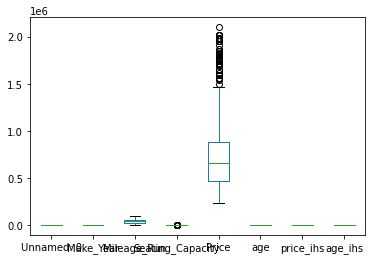

In [16]:
X.plot.box()

,Unnamed: 0,Make_Year,Mileage_Run,Seating_Capacity,Price,age,price_ihs,age_ihs
count,960.000000,960.000000,960.000000,960.0,9.600000e+02,960.000000,960.000000,960.000000
mean,491.894792,2016.891667,42111.321875,5.0,7.204990e+05,5.108333,14.101029,2.174949
std,280.553859,2.771585,24208.253958,0.0,3.123036e+05,2.771585,0.448406,0.604688
min,1.000000,2011.000000,1117.000000,5.0,2.370000e+05,1.000000,13.068963,0.881374
25%,250.750000,2015.000000,23203.750000,5.0,4.717500e+05,3.000000,13.757351,1.818446
50%,493.500000,2017.000000,38151.500000,5.0,6.615000e+05,5.000000,14.095412,2.312438
75%,734.250000,2019.000000,58192.000000,5.0,8.822500e+05,7.000000,14.383378,2.644121
max,976.000000,2021.000000,99495.000000,5.0,1.498000e+06,11.000000,15.250595,3.093102


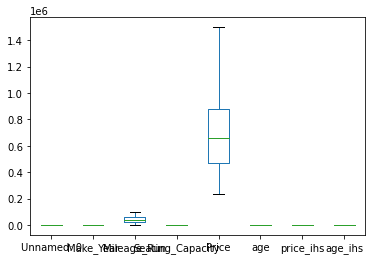

In [17]:
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

X.apply(windsorize)
X.plot.box()

X.describe()

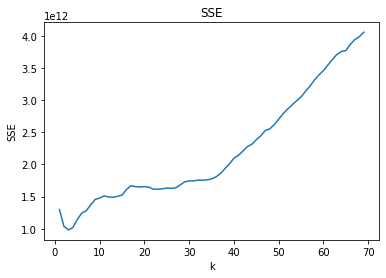

In [18]:
# Q1 part 4:

from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()


In [19]:
## Fit optimal model:
model = KNeighborsRegressor(n_neighbors=max(3,k_star))
knn_star = model.fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)
residuals_knn = y_test - y_hat_knn

In [20]:
## Metrics:
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )

MSE_knn = SSE_knn/N_test

RMSE_knn = (SSE_knn/N_test)**(1/2)
print(RMSE_knn, '\n')
R2_knn = 1 - SSE_knn/TSS
print(R2_knn, '\n')

71522.32719254203 

0.9663973106923196 



In [21]:
# The R^2 and RMSE on the test set are 0.966 and 71522 respectively. This is a very high RMSE value, which I assume
# because a lot of the numeric variables are very different in magnitude from each other.

In [22]:
# Now I will repeat this entire process with the categorical variables

# X = df.drop('Unnamed: 0',axis=1).drop('Make_Year',axis=1).drop('Mileage_Run',axis=1).drop('Seating_Capacity',axis=1).drop('Price',axis=1).drop('age',axis=1).drop('price_ihs',axis=1).drop('age_ihs',axis=1)
# selected_columns = ['Make', 'Body_Type', 'Fuel_Type']
selected_columns = ['Body_Type']
X = df[selected_columns]

y = df['Price'] # Create target variable vector

# This time I am creating a feature matrix with categorical values by using one-hot enconder
ddf = pd.get_dummies(X,dtype='int')
X=ddf
X.head()

,Body_Type_crossover,Body_Type_hatchback,Body_Type_muv,Body_Type_sedan,Body_Type_suv
0,0,0,0,1,0
1,1,0,0,0,0
2,0,0,0,0,1
3,0,1,0,0,0
4,0,1,0,0,0


In [23]:
## Test-train split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

<AxesSubplot:>

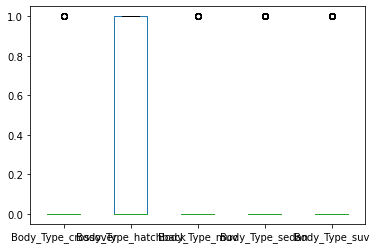

In [24]:
X.plot.box()

<AxesSubplot:>

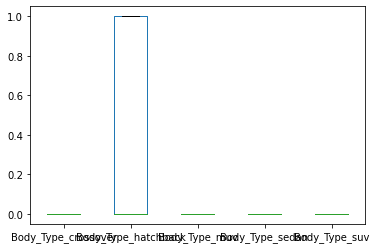

In [25]:
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

X.apply(windsorize)
X.plot.box()

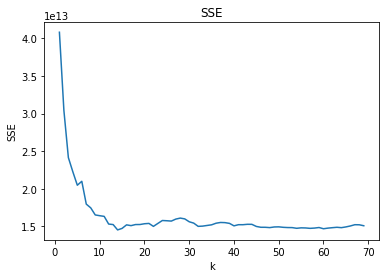

In [26]:
from sklearn.neighbors import KNeighborsRegressor

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)

# Determine optimal k:
k_bar = 70
k_grid = np.arange(1,k_bar) # The range of k's to consider
SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
for k in range(k_bar-1):
    model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
    fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
    y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
    SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
SSE_min = np.min(SSE) # Lowest recorded SSE
min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
k_star = k_grid[min_index][0] # Find the optimal value of k

## SSE plot:
plt.plot(k_grid,SSE)
plt.xlabel("k")
plt.ylabel("SSE")
plt.title('SSE')
plt.show()


In [27]:
## Fit optimal model:
model = KNeighborsRegressor(n_neighbors=max(3,k_star))
knn_star = model.fit(X_train_knn,y_train)
y_hat_knn = knn_star.predict(X_test_knn)
residuals_knn = y_test - y_hat_knn

In [28]:
## Metrics:
SSE_knn = np.sum( (y_test-y_hat_knn)**2 )

MSE_knn = SSE_knn/N_test

RMSE_knn = (SSE_knn/N_test)**(1/2)
print(RMSE_knn, '\n')
R2_knn = 1 - SSE_knn/TSS
print(R2_knn, '\n')

275019.9048725482 

0.5031571808969568 



In [29]:
# Here my R^2 and RMSE values are 0.5 and 275019 respectively, which is pretty bad... When I was running this model
#, I came across a lot of problems. The main problem was that after creating dummy variables for all the categorical
# variables, it was too much for the optimal k for loop. Thus, I ended up just using the most 'user-friendly' categorical
# variable: 'Body Type'. This variable was simple enough for the computer to handle, and I was able to regress the model
# compute the R^2 and RMSE values.

In [30]:
# Based on the RMSE values that I got from my numeric and categorical models, I think it's safe to say that
# the better performing model is the numeric model. The most logical reason behind this is the sklearn is built of
# using integers, so numeric variables that are already int types make the model run more effectively. Even though I
# changed the categorical variable Body_Type into a dummy variable, it isn't as cohesive for sklearn compared to the numeric
# model.

In [205]:
# Q1 part 5
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures


# Getting the numerica dataframe again:

y = df['Price'] # Create target variable vector

# Create feature matrix with numeric variables only
X = df.drop('Make',axis=1).drop('Color',axis=1).drop('Body_Type',axis=1).drop('No_of_Owners',axis=1).drop('Fuel_Type',axis=1).drop('Transmission',axis=1).drop('Transmission_Type',axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

X.apply(windsorize)


# PolynomialFeatures function with the numerical variables
expander = PolynomialFeatures(degree=3,include_bias=False) # Create the expander
#
# Z_train = expander.fit_transform(X_train) # Pass the df into the expander to get powers/interactions of x and y
# names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = expander.fit_transform(X_train) # Create a new, expanded dataframe
#
# Z_test = expander.fit_transform(X_test) # Pass the df into the expander to get powers/interactions of x and y
# names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = expander.fit_transform(X_test) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model

# Predicted values:
y_hat_lm = reg.predict(X_test_lm)
residuals_lm = y_test - y_hat_lm

## Metrics:
SSE_lm = np.sum( (y_test-y_hat_lm)**2 )
MSE_lm = SSE_lm/N_test
RMSE_lm = (SSE_lm/N_test)**(1/2)
print(RMSE_lm,'\n')
R2_lm = 1 - SSE_lm/TSS
print(R2_lm,'\n')

0.004418239009627898 

0.9999999999999999 



In [206]:
# After using the polynomial expander on the numeric variables, my RMSE and R^2 values got a lot better,
# being 0.004 and 0.999 respectively. As I increase the degree of expansion from 3 to 4, the RMSE value
# increases to 8.9 while the the R^2 value increases slightly.However, if I decrease the degree of expansion 
# from 3 to 2, the RMSE value becomes negative. R^2 becomes negative at degree 10

# When I compare the best expander model (with degree 3) to my best original numeric model, I see a massive
# amount of improvement in the data.

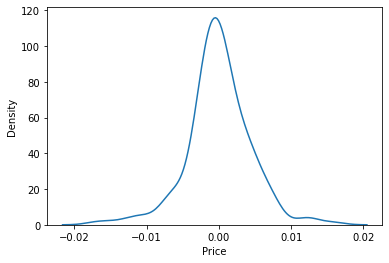

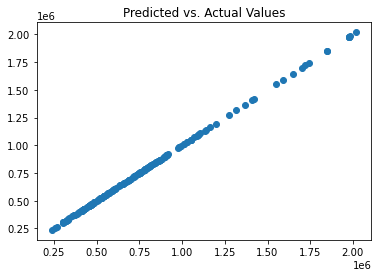

In [207]:
# Q1 part 6:

# Fit the model and get the R2 measure:
reg = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model

# Predicted values:
y_hat_lm = reg.predict(X_test_lm)
residuals_lm = y_test - y_hat_lm

## Residual plot:
sns.kdeplot(residuals_lm)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_lm,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

In [208]:
# In general, these the plots of the residuals and predicted vs. actual values look
# decent. I noticed that for the residuals of price, even though the bell curve is around
# 0, there is a lot of skew-left values, particularly negative. This is a bit weird and I'm
# not entirely sure what this signifies.

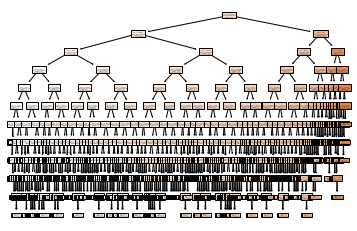

4734.074179111828 

0.9998527820114407 



In [209]:
# Q1 part 7:

from sklearn import tree 

model = tree.DecisionTreeRegressor(max_depth=20) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True) 
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
print(RMSE_cart,'\n')
R2_cart = 1 - SSE_cart/TSS
print(R2_cart,'\n')

In [210]:
# When using the tree of depth 10, my RMSE and R^2 values respectively are 6221 and 0.9997. When I increased the
# depth to 15, the RMSE value decreases to 4503 and the R^2 value increases slightly. When increases the depth to 20,
# the RMSE value decreases to 4287.

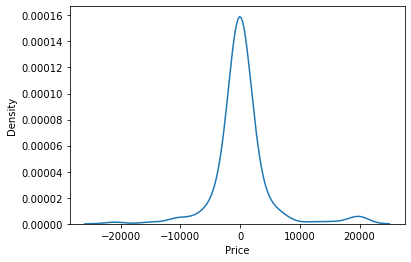

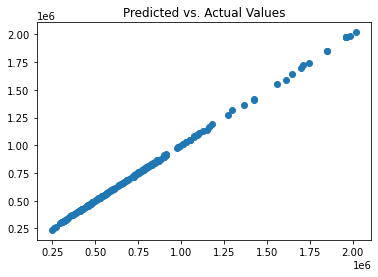

In [211]:
# Q1 part 8:

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

In [212]:
# The residual data looks roughly bell-shaped around 0

In [213]:
# Q1 part 9:

# When comparing the linear model versus tree, I would say that the linear model has a better
# performance on the test set because the RMSE value is a lot lower. This means that model's predictions
# were closer to the actual value.

Based on the data, I can see that the most expensive car brands are MG Motors, Kia, and Jeep.
In general, prices are average out at 7.380156e+05

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set? 
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4? 
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

In [31]:
# Q2 part 1:
df = pd.read_csv('./data/wages_hw.csv')
df.head()

,Unnamed: 0,Rating,Size,Sector,avg_salary,job_state
0,1,3.8,501 to 1000 employees,Aerospace & Defense,72.0,NM
1,2,3.4,10000+ employees,Health Care,87.5,MD
2,3,4.8,501 to 1000 employees,Business Services,85.0,FL
3,4,3.8,1001 to 5000 employees,"Oil, Gas, Energy & Utilities",76.5,WA
4,5,2.9,51 to 200 employees,Business Services,114.5,NY


In [32]:
# I want to one-hot-encode the categorical variables into dummy varialbes, and then
# concatenate this new dataframe with the original

# Numeric dataframe:
columns_to_drop = ['Size', 'Sector', 'job_state']
ndf = df.drop(columns=columns_to_drop, axis=1)
ndf.head()

# Categorical dataframe:
columns_to_drop = ['Unnamed: 0', 'Rating', 'avg_salary']
cdf = df.drop(columns=columns_to_drop, axis=1)
cdf.head()

# One-hot_encoding categorical dataframe:
# columns_to_encode = ['Size', 'Sector', 'job_state']
# odf = pd.get_dummies(cdf, columns=columns_to_encode, drop_first=True, dtype=float)

odf = pd.get_dummies(cdf, drop_first=True, dtype=float)
odf.head()

df = pd.concat([ndf, odf], axis=1)
df.head()

,Unnamed: 0,Rating,avg_salary,Size_10000+ employees,Size_1001 to 5000 employees,Size_201 to 500 employees,Size_5001 to 10000 employees,Size_501 to 1000 employees,Size_51 to 200 employees,Size_Unknown,...,job_state_ OR,job_state_ PA,job_state_ RI,job_state_ SC,job_state_ TN,job_state_ TX,job_state_ UT,job_state_ VA,job_state_ WA,job_state_ WI
0,1,3.8,72.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,3.4,87.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,4.8,85.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,3.8,76.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,2.9,114.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
y = df['avg_salary'] # Create target variable vector

<AxesSubplot:>

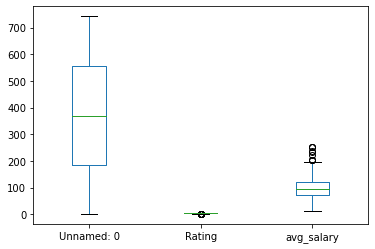

In [34]:
ndf.plot.box()

<AxesSubplot:>

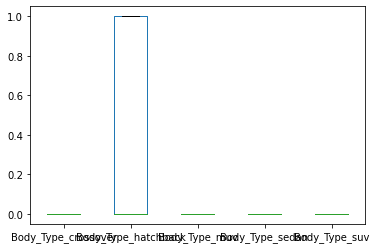

In [35]:
# Cleaning variables using windosor function:
X.apply(windsorize)
X.plot.box()

In [65]:
def slr(x,y): # Single Linear Regression Function
    x_bar = np.mean(x) # Average of x's
    y_bar = np.mean(y) # Average of y's
    b1 = np.inner(x-x_bar,y-y_bar)/np.inner(x-x_bar,x) # Slope coefficient
    b0 = y_bar - b1*x_bar # Intercept coefficient
    y_hat = b0 + b1*x   # Compute predictions
    residuals = y - y_hat   # Compute residuals
    return({'b0':b0,'b1':b1,'y_hat':y_hat,'residuals':residuals})

In [66]:
x = df['avg_salary']
y = sector_num = pd.get_dummies(cdf['Sector'], drop_first=True, dtype=float)

coef = slr(x,y)

y_hat = coef['b0']+coef['b1']*x

plt.scatter(x,y,label='Data')
plt.plot(x,y_hat,label='Regression Line',color='black')
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.title('Linear Regression')
plt.show()

ValueError: shapes (731,) and (24,731) not aligned: 731 (dim 0) != 24 (dim 0)

In [67]:
# Question 2 part 2:

y = ndf['avg_salary'] # Create target variable vector

# Create feature matrix with sector

X = sector_num = pd.get_dummies(cdf['Sector'], drop_first=True, dtype=float)
X.head()

,Accounting & Legal,Aerospace & Defense,Agriculture & Forestry,"Arts, Entertainment & Recreation",Biotech & Pharmaceuticals,Business Services,"Construction, Repair & Maintenance",Consumer Services,Education,Finance,...,Manufacturing,Media,Mining & Metals,Non-Profit,"Oil, Gas, Energy & Utilities",Real Estate,Retail,Telecommunications,Transportation & Logistics,Travel & Tourism
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

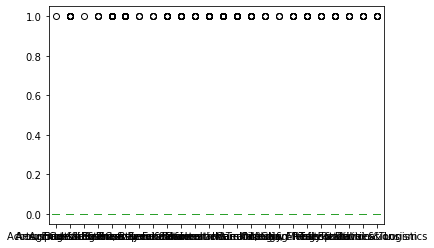

In [68]:
# X.apply(windsorize)
X.plot.box()

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

In [70]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.preprocessing import PolynomialFeatures

# Maxmin normalization function:
def maxmin(z):
    z = (z-min(z))/(max(z)-min(z))
    return(z)

# Apply maxmin to each column of X:
X_train_knn = X_train.apply(maxmin)
X_test_knn = X_test.apply(maxmin)



In [71]:
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
print(reg.score(X_test, y_test)) # R squared measure

0.08596457751815356


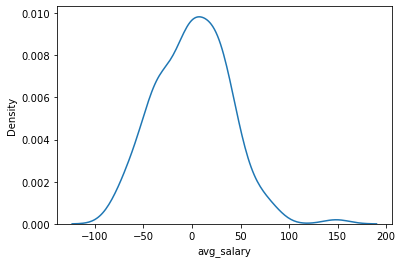

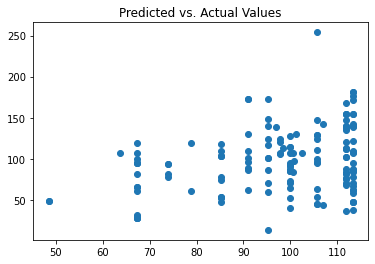

37.50577913830052 

0.0902411096414174 



In [72]:
# Predicted values:
y_hat = reg.predict(X_test)
residuals = y_test - y_hat

## Residual plot:
sns.kdeplot(residuals)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()

## Metrics:
SSE = np.sum( (y_test-y_hat)**2 )
MSE = SSE/N_test
RMSE = (SSE/N_test)**(1/2)
R2 = 1 - SSE/TSS
print(RMSE,'\n')
print(R2, '\n')

In [ ]:
# The RMSE value is 37.506 for this data, with a R2 of 0.09. 

In [73]:
# from sklearn.neighbors import KNeighborsRegressor

# # Maxmin normalization function:
# def maxmin(z):
#     z = (z-min(z))/(max(z)-min(z))
#     return(z)

# # Apply maxmin to each column of X:
# X_train_knn = X_train.apply(maxmin)
# X_test_knn = X_test.apply(maxmin)

# # Determine optimal k:
# k_bar = 4
# k_grid = np.arange(1,k_bar) # The range of k's to consider
# SSE = np.zeros(k_bar-1) # For comparison purposes, store the training error
# for k in range(k_bar-1):
#     model = KNeighborsRegressor(n_neighbors=k+1) # Create a sk model for k
#     fitted_model = model.fit(X_train_knn,y_train) # Train the model on our data
#     y_hat = fitted_model.predict(X_test_knn) # Predict values for test set
#     SSE[k] = np.sum( (y_test-y_hat)**2 ) # Save the computed SSE
# SSE_min = np.min(SSE) # Lowest recorded SSE
# min_index = np.where(SSE==SSE_min) # Find the indices of y that equal the minimum
# k_star = k_grid[min_index][0] # Find the optimal value of k
# print(k_star)

# ## SSE plot:
# plt.plot(k_grid,SSE)
# plt.xlabel("k")
# plt.ylabel("SSE")
# plt.title('SSE')
# plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<AxesSubplot:>

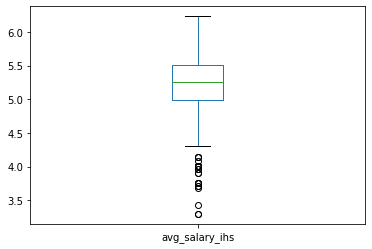

In [186]:
# Q2 part 3

df = df = pd.read_csv('./data/wages_hw.csv')
df['avg_salary_ihs'] = np.arcsinh(df['avg_salary'])
df['Rating_ihs'] = np.arcsinh(df['Rating'])
df['avg_salary_ihs'].plot.box()

<AxesSubplot:>

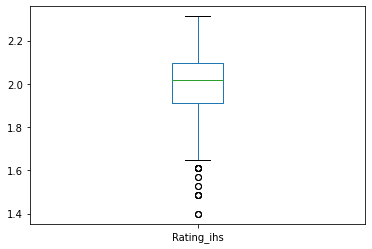

In [187]:
df['Rating_ihs'].plot.box()

<AxesSubplot:xlabel='Rating_ihs', ylabel='avg_salary_ihs'>

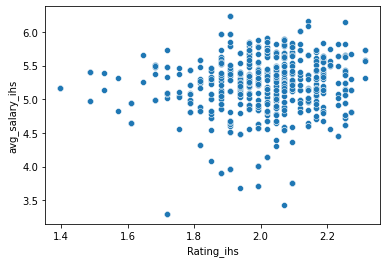

In [188]:
sns.scatterplot(data=df,y='avg_salary_ihs',x='Rating_ihs')

In [189]:
# From this scatter plot, there isn't any obvious relationship between rating and avg_salary

In [190]:
# Cleaning rating and avg_salary:

df =  df.loc[df['avg_salary_ihs']>4.25,:] 
df = df.loc[df['Rating_ihs']>1.7,:]

<AxesSubplot:xlabel='Rating_ihs', ylabel='avg_salary_ihs'>

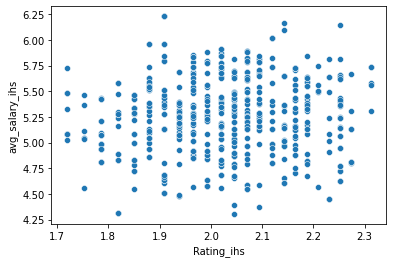

In [191]:
sns.scatterplot(data=df,x='Rating_ihs',y='avg_salary_ihs')

Intercept:  4.669479426532151 
  Slope:  0.2952540876033145


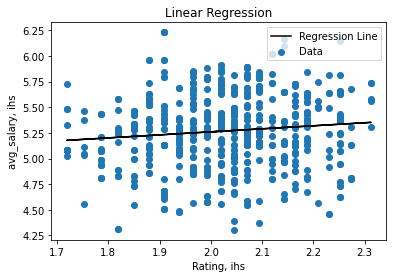

In [192]:
x = df['Rating_ihs']
y = df['avg_salary_ihs']

coef = slr(x,y) # Single Linear Regression
print('Intercept: ',coef['b0'], '\n', ' Slope: ', coef['b1']) 

y_hat = coef['b0']+coef['b1']*x # Compute predictions

# Scatter plot of fit:
plt.scatter(x,y,label='Data')
plt.plot(x,y_hat,label='Regression Line',color='black')
plt.xlabel("Rating, ihs")
plt.ylabel("avg_salary, ihs")
plt.legend(loc='upper right')
plt.title('Linear Regression')

plt.show()

In [ ]:
# Higher ratings barely predict higher avg_salary according to the line of best fit

In [182]:
Rating_cat = pd.get_dummies(df['Rating_ihs'], drop_first=True, dtype=float)
Rating_cat

,1.753229,1.786340,1.818446,1.849604,1.879864,1.909274,1.937879,1.965720,1.992836,2.019261,...,2.094713,2.118685,2.142112,2.165017,2.187422,2.209348,2.230814,2.251840,2.272441,2.312438
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
729,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [183]:
df['avg_salary_ihs'].head()

0    4.969862
1    5.164819
2    5.135833
3    5.030481
4    5.433741
Name: avg_salary_ihs, dtype: float64

In [144]:
import pandas as pd

cat_rating = Rating_cat.to_numpy()

# Rating_cat = int(Rating_cat)


# Now 'array_from_table' is a NumPy array
print(cat_rating.shape)
print(df['avg_salary_ihs'].shape,'\n')

(673, 22)
(673,) 



In [197]:
x = cat_rating.reshape(673,22)
y = df['avg_salary_ihs'].to_numpy().reshape(1,-1)

coef = slr(x,y) # Single Linear Regression
print('Intercept: ',coef['b0'], '\n', ' Slope: ', coef['b1']) 

y_hat = coef['b0']+coef['b1']*x # Compute predictions

# Scatter plot of fit:
plt.scatter(x,y,label='Data')
plt.plot(x,y_hat,label='Regression Line',color='black')
plt.xlabel("Rating (categorical), ihs")
plt.ylabel("avg_salary, ihs")
plt.legend(loc='upper right')
plt.title('Linear Regression')

plt.show()

ValueError: shapes (673,22) and (673,1) not aligned: 22 (dim 1) != 673 (dim 0)

In [198]:
# I'm not able to figure out what to do in this case. I am running into a problem where my one-hot encoded
# variable of Rating has 22 columns and 673 rows, whereas my avg_salary data only has 1 column with 673 rows.
# Python isn't letting me run a regression on these variables because their shapes are mismatched. Not really sure
# how to proceed from here...

In [199]:
# Q2 part 6:

y = df['avg_salary_ihs'] # Create target variable vector

# Create feature matrix with sector
X = pd.get_dummies(df['Sector'], drop_first=True, dtype=float)
X.head()

# from sklearn import tree 

# model = tree.DecisionTreeRegressor(max_depth=20) # Fit the classifier
# cart = model.fit(X_train, y_train)
# tree.plot_tree(cart,filled=True) 
# plt.show()

# ## Make Predictions on the Test Set
# y_hat_cart = cart.predict(X_test)
# residuals_cart = y_test - y_hat_cart


# ## Metrics:
# SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
# MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
# RMSE_cart = (SSE_cart/N_test)**(1/2)
# print(RMSE_cart,'\n')
# R2_cart = 1 - SSE_cart/TSS
# print(R2_cart,'\n')

,Accounting & Legal,Aerospace & Defense,Agriculture & Forestry,"Arts, Entertainment & Recreation",Biotech & Pharmaceuticals,Business Services,Consumer Services,Education,Finance,Government,...,Manufacturing,Media,Mining & Metals,Non-Profit,"Oil, Gas, Energy & Utilities",Real Estate,Retail,Telecommunications,Transportation & Logistics,Travel & Tourism
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [200]:
# Once again, my problem is that my one-hot-encoded variable has a shape 2D shape instead of 1D, but I am not
# able to convert it to 1D because then the number of rows greatly outnumbers the number of rows in avg_salary.
# Ultimately, I can only run regression/trees on avg_salary and rating because the shapes of both of these varaibles
# are equivalent. I will ask in office hours how to overcome this problem.

In [206]:
y = df['avg_salary_ihs'] # Create target variable vector

# Create feature matrix with rating

X = df['Rating_ihs']
# X.head()

from sklearn import tree 

model = tree.DecisionTreeRegressor(max_depth=20) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True) 
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
print(RMSE_cart,'\n')
R2_cart = 1 - SSE_cart/TSS
print(R2_cart,'\n')

ValueError: Expected 2D array, got 1D array instead:
array=[2.0947125 2.2518396 1.7863402 2.0192606 2.0701692 2.2518396 2.2518396
 1.9928358 2.0947125 2.0450282 1.909274  1.8798636 1.9378793 2.0450282
 2.0192606 1.9657204 1.8798636 1.8496037 2.0701692 1.9928358 2.142112
 2.2518396 1.7863402 2.118685  1.8798636 2.1650167 2.0701692 2.2518396
 2.0947125 2.0192606 1.8496037 2.118685  2.0192606 2.0947125 2.1874218
 1.8798636 1.9657204 2.0947125 2.0450282 1.7532289 2.118685  2.1874218
 2.1874218 2.0701692 1.8798636 2.0192606 1.9657204 1.8798636 2.1874218
 1.8798636 2.2308142 2.0450282 2.0947125 2.0192606 2.142112  1.909274
 1.9928358 2.0701692 1.9378793 1.8184465 2.0192606 1.9378793 2.0947125
 2.0192606 1.9657204 2.118685  2.142112  1.7190518 2.2308142 2.0701692
 2.142112  2.0450282 2.1874218 2.118685  1.9378793 2.142112  2.0192606
 2.0192606 2.0192606 2.0192606 2.2093477 2.0192606 1.9928358 2.1650167
 1.9378793 1.7190518 2.0450282 2.0701692 1.9928358 2.2518396 2.1874218
 2.0450282 2.142112  2.0450282 1.9378793 1.9378793 1.8798636 1.9657204
 1.8798636 1.8798636 2.1874218 2.118685  1.9928358 1.9657204 2.0450282
 2.2093477 2.3124382 2.118685  2.0450282 1.8496037 2.1874218 1.7190518
 2.0450282 2.0947125 1.9657204 2.142112  2.2518396 1.9928358 2.2093477
 2.0701692 1.8798636 2.0701692 1.8496037 2.0192606 1.9657204 2.118685
 2.0192606 2.0701692 2.1650167 2.1650167 1.8798636 2.0450282 1.909274
 1.7863402 2.0701692 2.118685  2.1650167 1.9378793 1.8798636 2.0192606
 2.1650167 2.118685  1.909274  1.8184465 2.2093477 1.9928358 2.0192606
 2.2518396 2.0450282 2.142112  1.8184465 2.2518396 2.0450282 1.909274
 1.8798636 1.9378793 2.0701692 1.9657204 1.9928358 2.0701692 2.0701692
 2.0450282 1.9928358 2.0192606 1.9378793 2.0947125 2.142112  1.7190518
 1.9378793 2.0947125 1.9928358 2.0192606 1.8798636 1.7863402 2.1874218
 2.0450282 2.142112  1.7863402 2.1874218 2.0450282 2.0450282 2.0701692
 2.0192606 2.0450282 2.1650167 1.9657204 2.0947125 1.9657204 2.0450282
 2.2308142 1.8184465 1.9657204 2.0701692 1.9657204 2.0192606 2.0947125
 2.118685  2.0947125 2.0947125 2.0192606 1.9657204 2.0192606 1.8496037
 1.909274  2.1650167 1.9928358 1.7863402 1.8496037 2.0947125 2.0450282
 1.9928358 1.8798636 1.8496037 1.8184465 2.0947125 2.1874218 2.0450282
 1.909274  2.0450282 2.1650167 2.1874218 2.1650167 1.8184465 2.0947125
 2.0701692 2.2518396 1.8184465 1.9378793 1.8496037 2.1874218 2.2518396
 1.9657204 1.9928358 1.8496037 1.8184465 1.8798636 2.0450282 2.2093477
 2.0192606 1.8496037 2.2518396 2.0192606 1.8184465 1.9928358 2.0701692
 2.2724414 1.8798636 2.1650167 1.909274  1.9657204 2.0450282 1.9657204
 2.0450282 2.3124382 2.0450282 2.0192606 2.0192606 2.0701692 2.142112
 1.909274  1.9378793 2.2724414 2.2518396 2.0192606 1.9657204 2.142112
 1.8798636 2.2093477 2.0192606 1.9657204 1.8496037 1.8496037 2.0450282
 2.0701692 2.1874218 1.9657204 2.0192606 1.8496037 1.8496037 1.9657204
 1.9657204 2.0192606 2.0947125 1.9928358 2.0450282 2.1874218 1.9378793
 2.1650167 1.8496037 2.0450282 1.9928358 2.0192606 2.1874218 2.0701692
 2.0701692 1.7532289 2.2518396 2.0701692 1.909274  1.7863402 2.142112
 2.0450282 1.7190518 2.0701692 2.0450282 2.2308142 1.9657204 2.0450282
 2.0947125 2.0192606 1.8798636 2.1874218 1.8798636 2.2724414 2.0450282
 2.1874218 1.9657204 2.0192606 1.9928358 2.1874218 2.0450282 2.2724414
 1.909274  2.0947125 2.0701692 1.9657204 1.909274  2.0192606 2.0701692
 1.8496037 2.2093477 1.9378793 1.8798636 2.0450282 2.0701692 1.7190518
 2.3124382 2.0701692 1.909274  2.2518396 1.7863402 1.7863402 1.9378793
 2.0192606 2.1874218 2.1874218 2.1650167 2.2518396 1.9928358 2.0192606
 1.8496037 2.0947125 1.9928358 2.0701692 1.9657204 2.142112  1.9928358
 2.0701692 2.0947125 2.2518396 2.0192606 2.0192606 2.1650167 2.142112
 1.9657204 2.2724414 2.0450282 2.1650167 1.909274  2.1874218 1.8496037
 2.0947125 2.0450282 1.9928358 1.909274  1.9928358 1.9657204 2.0701692
 2.0701692 2.0947125 1.9928358 2.0450282 2.0947125 2.1650167 1.909274
 2.0701692 1.909274  2.0701692 2.2518396 2.0192606 2.0701692 2.0947125
 1.9378793 2.142112  2.2518396 1.8798636 2.0701692 1.8184465 1.9657204
 2.118685  2.0701692 1.8798636 1.7863402 1.7190518 2.0450282 1.9378793
 1.8184465 2.1650167 2.118685  1.9378793 2.0701692 2.0192606 1.8798636
 1.8496037 1.9378793 1.7532289 1.9657204 1.9378793 2.118685  1.8184465
 2.0450282 1.9657204 1.8798636 2.0450282 2.2518396 2.1650167 1.909274
 1.7863402 2.2518396 2.1650167 1.9378793 1.9928358 1.9928358 2.2308142
 2.0450282 2.1650167 1.9657204 2.0701692 2.0947125 2.118685  1.9657204
 2.0947125 1.909274  2.1650167 2.1874218 1.9928358 2.0947125 1.9657204
 2.0701692 1.8496037 2.0192606 1.7863402 2.0450282 1.9378793 2.0701692
 2.0192606 2.0450282 2.1874218 2.0192606 2.0701692 1.7863402 1.9378793
 1.9928358 1.7863402 1.909274  1.8496037 2.0701692 1.9657204 2.0450282
 2.1650167 2.142112  2.0450282 1.9928358 1.8184465 2.2518396 2.0947125
 2.142112  2.1650167 2.118685  1.9657204 1.9378793 2.3124382 1.909274
 1.909274  1.8798636 1.7532289 2.0450282 1.8798636 2.2518396 2.0450282
 2.0701692 2.2308142 1.909274  2.1650167 2.0701692 2.0192606 1.9657204
 1.9378793 2.0450282 2.1650167 2.0450282 1.8184465 2.0701692 1.9657204
 2.2724414 1.9657204 2.1650167 2.0701692 2.2518396 1.9378793 2.1874218
 2.0947125 2.0701692 1.8184465 1.7863402 2.3124382 2.142112  2.0947125
 2.1650167 2.0947125 2.0450282 2.1874218 2.0947125 1.9378793 2.0192606
 1.7190518 1.8798636 2.0701692 1.9928358 2.118685  2.0947125 1.9928358
 1.9378793 1.9928358 1.9378793 1.9657204 2.0192606 1.909274 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high 
    - Husband's education (categorical) 1=low, 2, 3, 4=high 
    - Number of children ever born (numerical) 
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent 
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where 
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?